# RNN Implementation and Experiments

This notebook demonstrates the RNN implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader
from src.models.src.models.rnn.experiment import RNNExperiments
from src.models.src.models.rnn.rnn_model import RNNModel
from src.models.src.models.rnn.rnn_layer import RNNLayer
from src.models.src.models.base_model.layers.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


## 1. Load Data

In [ ]:
# Init data loader
data_loader = NusaXLoader(batch_size=32, add=True)
# Ini add buat ngubah pathnya nambah "../" tapi harusnya gaperlu soalnya di file siblingnsnya juga gapake ini, api entah kenapa gabisa jalan kalo gadipasang
# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Decode a few examples
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with RNN

In [9]:
experiments = RNNExperiments(data_loader=data_loader, batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of RNN Layers


=== Training model with 1 RNN Layer ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748575563.938430    2485 service.cc:152] XLA service 0x754f1000a1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748575563.938500    2485 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-30 10:26:04.022813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748575564.274303    2485 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4143 - loss: 1.0919

I0000 00:00:1748575566.331988    2485 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.3906 - loss: 1.1051 - val_accuracy: 0.3800 - val_loss: 1.0849
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3971 - loss: 1.0737 - val_accuracy: 0.2300 - val_loss: 1.2053
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4060 - loss: 1.1148 - val_accuracy: 0.3300 - val_loss: 1.1708
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4100 - loss: 1.1096 - val_accuracy: 0.4200 - val_loss: 1.0948
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3227 - loss: 1.2771 - val_accuracy: 0.3800 - val_loss: 1.1227
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3649 - loss: 1.1437 - val_accuracy: 0.3800 - val_loss: 1.1428
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4265 - loss: 1.1171 - val_accuracy: 0.3600 - val_loss: 1.0937
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3562 - loss: 1.1379 - val_accuracy: 0.3700 - val_loss: 1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with 2 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-30 10:26:23.334415: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_60', 8 bytes spill stores, 8 bytes spill loads



15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3464 - loss: 1.1524

2025-05-30 10:26:27.954219: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_60', 8 bytes spill stores, 8 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.3487 - loss: 1.1511 - val_accuracy: 0.3800 - val_loss: 1.1032
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4125 - loss: 1.0572 - val_accuracy: 0.2600 - val_loss: 1.3269
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5135 - loss: 1.0109 - val_accuracy: 0.4200 - val_loss: 1.2880
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6397 - loss: 0.8242 - val_accuracy: 0.3500 - val_loss: 1.4821
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5392 - loss: 0.9964 - val_accuracy: 0.2800 - val_loss: 1.5331
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.4567 - loss: 1.1353 - val_accuracy: 0.2900 - val_loss: 1.1463
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3528 - loss: 1.2197 - val_accuracy: 0.4500 - val_loss: 1.1381
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3032 - loss: 1.2807 - val_accuracy: 0.3700 - val_loss: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 976,379 (3.72 MB)

 Trainable params: 325,459 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 650,920 (2.48 MB)


=== Training model with 3 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.3694 - loss: 1.2156 - val_accuracy: 0.3800 - val_loss: 1.0907
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3612 - loss: 1.2667 - val_accuracy: 0.3800 - val_loss: 1.1064
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3600 - loss: 1.2371 - val_accuracy: 0.3800 - val_loss: 1.1075
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3153 - loss: 1.2249 - val_accuracy: 0.3800 - val_loss: 1.0959
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.3211 - loss: 1.2382 - val_accuracy: 0.3800 - val_loss: 1.1204
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3423 - loss: 1.2474 - val_accuracy: 0.3800 - val_loss: 1.0861
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.3897 - loss: 1.1622 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3093 - loss: 1.2402 - val_accuracy: 0.3800 - val_loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,403 (3.76 MB)

 Trainable params: 328,467 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 656,936 (2.51 MB)

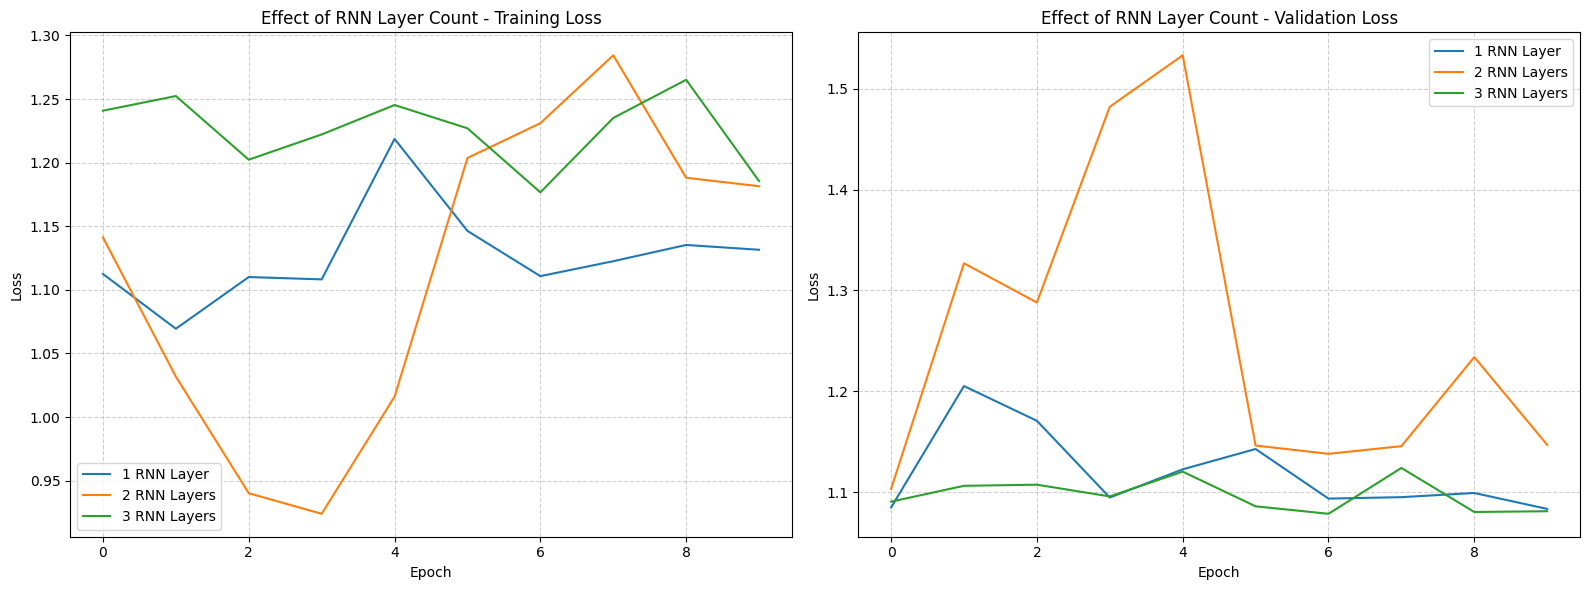

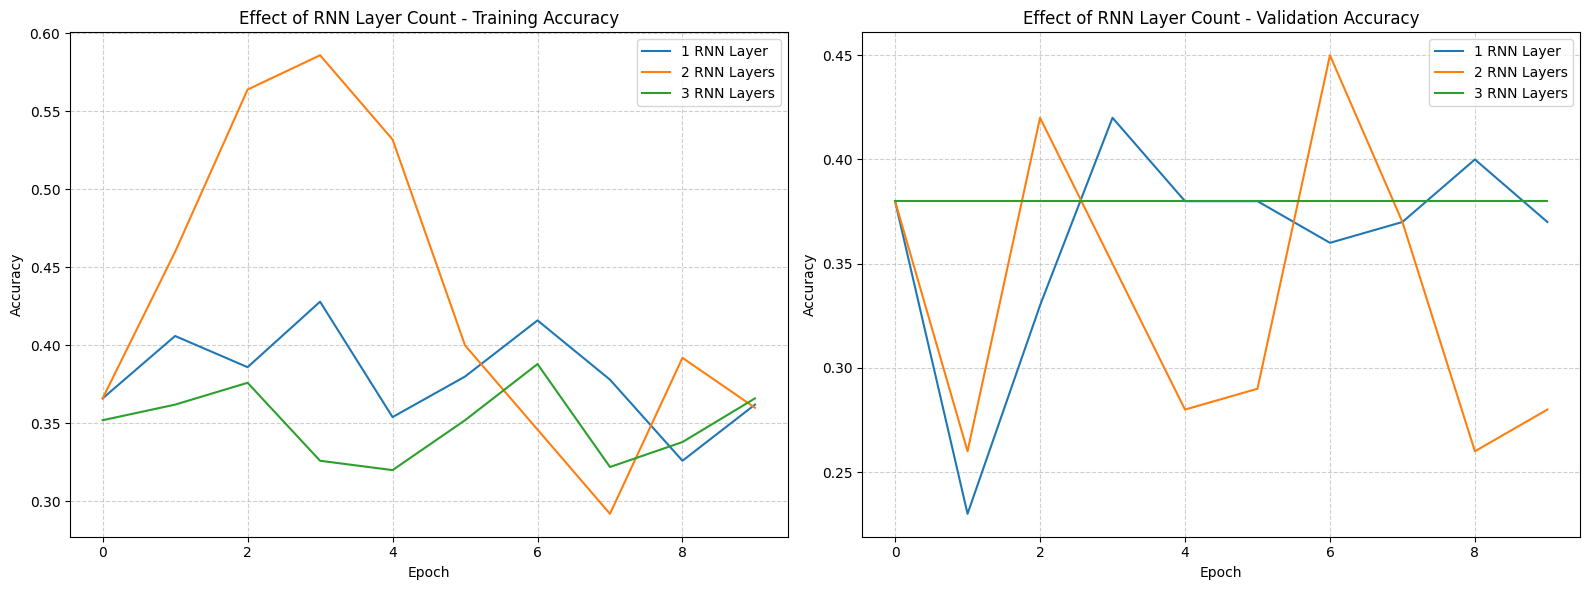

In [10]:
# Define variants for number of RNN layers
layer_count_variants = [
    (1, "1 RNN Layer"),
    (2, "2 RNN Layers"),
    (3, "3 RNN Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of RNN Cells per Layer


=== Training model with 32 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.4291 - loss: 1.0727 - val_accuracy: 0.3500 - val_loss: 1.0343
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5630 - loss: 0.9552 - val_accuracy: 0.4900 - val_loss: 1.1163
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.6330 - loss: 0.8939 - val_accuracy: 0.3600 - val_loss: 1.1209
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6845 - loss: 0.7961 - val_accuracy: 0.5500 - val_loss: 1.0799
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8317 - loss: 0.6200 - val_accuracy: 0.5700 - val_loss: 0.9786
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7096 - loss: 0.7236 - val_accuracy: 0.4900 - val_loss: 1.3830
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6306 - loss: 0.7918 - val_accuracy: 0.5400 - val_loss: 1.0543
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8358 - loss: 0.5518 - val_accuracy: 0.4800 - val_loss: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)


=== Training model with 64 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.3832 - loss: 1.0808 - val_accuracy: 0.5000 - val_loss: 1.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4928 - loss: 1.0163 - val_accuracy: 0.6000 - val_loss: 0.9427
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5646 - loss: 0.9433 - val_accuracy: 0.5500 - val_loss: 0.9248
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5806 - loss: 0.8925 - val_accuracy: 0.5500 - val_loss: 0.9601
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6412 - loss: 0.7455 - val_accuracy: 0.6200 - val_loss: 0.8406
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6581 - loss: 0.6926 - val_accuracy: 0.6000 - val_loss: 0.9010
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6835 - loss: 0.6557 - val_accuracy: 0.6000 - val_loss: 0.9734
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7077 - loss: 0.6107 - val_accuracy: 0.4500 - val_loss: 1

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 128 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.4183 - loss: 1.0991 - val_accuracy: 0.3900 - val_loss: 1.0781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4655 - loss: 1.0409 - val_accuracy: 0.3700 - val_loss: 1.1268
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3757 - loss: 1.1191 - val_accuracy: 0.3900 - val_loss: 1.1150
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4640 - loss: 1.0603 - val_accuracy: 0.4000 - val_loss: 1.1396
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4597 - loss: 1.0520 - val_accuracy: 0.3500 - val_loss: 1.1040
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4244 - loss: 1.0878 - val_accuracy: 0.3200 - val_loss: 1.2947
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4282 - loss: 1.1252 - val_accuracy: 0.4400 - val_loss: 1.0819
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3354 - loss: 1.1485 - val_accuracy: 0.3600 - val_loss: 1

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

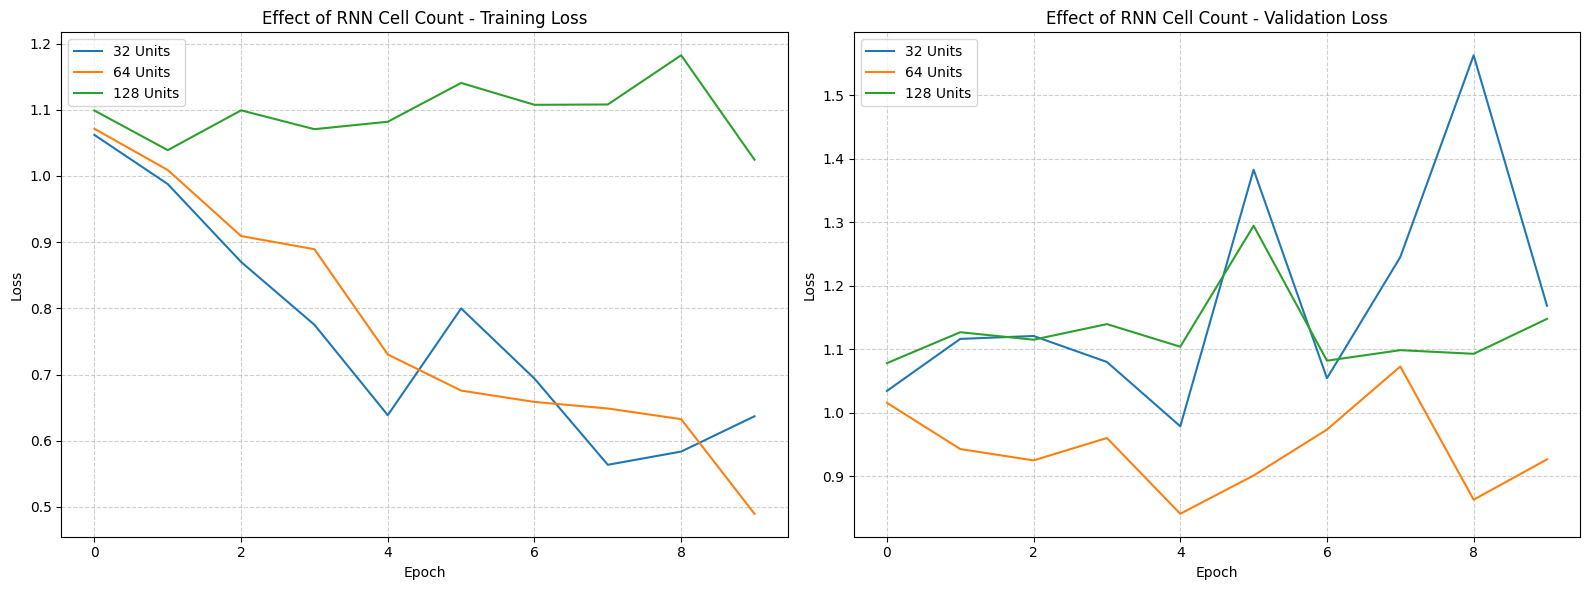

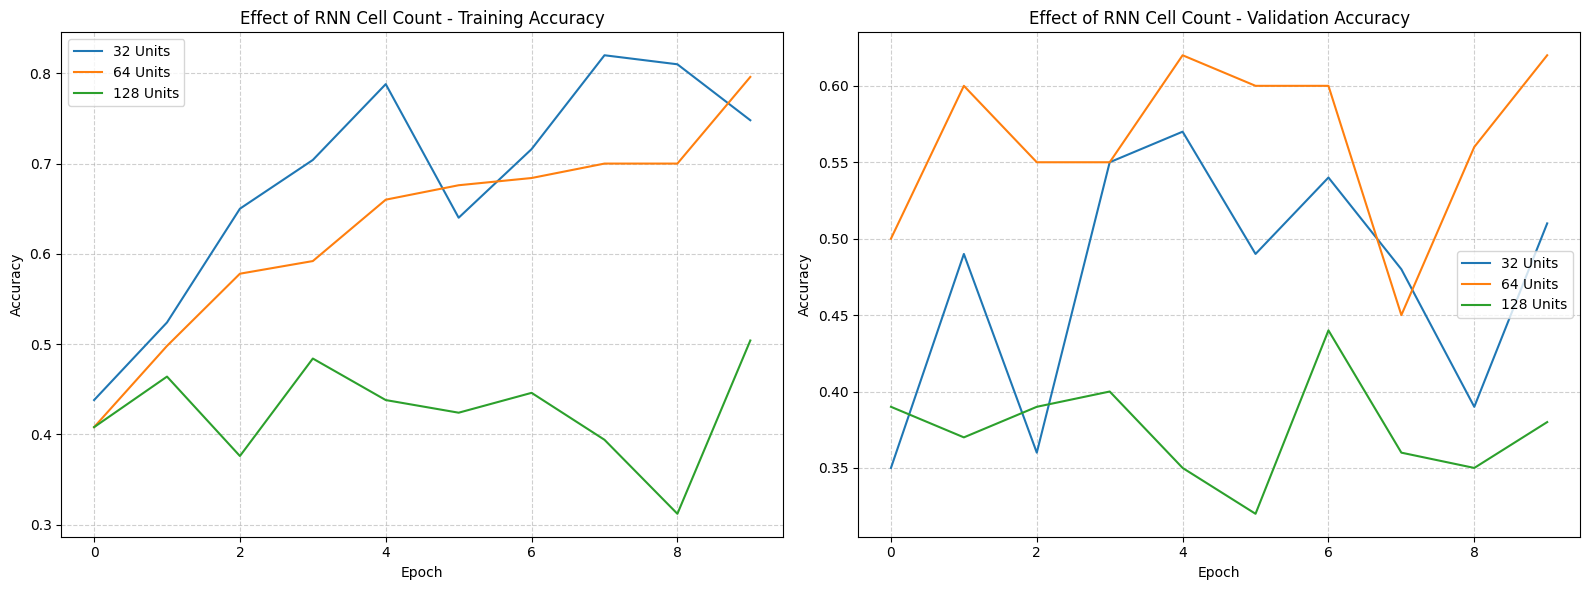

In [11]:
# Define variants for cell counts
cell_count_variants = [
    ([32], "32 Units"),
    ([64], "64 Units"),
    ([128], "128 Units")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)

### 2.3 Experiment: RNN Direction


=== Training model with Unidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.4143 - loss: 1.1027 - val_accuracy: 0.3700 - val_loss: 1.1130
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3818 - loss: 1.1252 - val_accuracy: 0.4100 - val_loss: 1.1177
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3187 - loss: 1.1761 - val_accuracy: 0.2600 - val_loss: 1.1471
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3291 - loss: 1.1594 - val_accuracy: 0.3800 - val_loss: 1.0924
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3145 - loss: 1.1315 - val_accuracy: 0.3800 - val_loss: 1.0866
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3484 - loss: 1.1204 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3725 - loss: 1.1209 - val_accuracy: 0.4200 - val_loss: 1.0785
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3253 - loss: 1.1354 - val_accuracy: 0.4100 - val_loss: 1

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with Bidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step - accuracy: 0.3608 - loss: 1.1127 - val_accuracy: 0.3700 - val_loss: 1.1042
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4416 - loss: 1.0620 - val_accuracy: 0.4500 - val_loss: 1.0736
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7647 - loss: 0.8036 - val_accuracy: 0.4600 - val_loss: 1.0203
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9359 - loss: 0.4476 - val_accuracy: 0.5100 - val_loss: 1.0098
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9676 - loss: 0.2084 - val_accuracy: 0.4700 - val_loss: 1.1089
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9811 - loss: 0.1029 - val_accuracy: 0.4300 - val_loss: 1.2085
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9917 - loss: 0.0618 - val_accuracy: 0.4500 - val_loss: 1.2682
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9971 - loss: 0.0295 - val_accuracy: 0.4100 - val_loss: 1

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

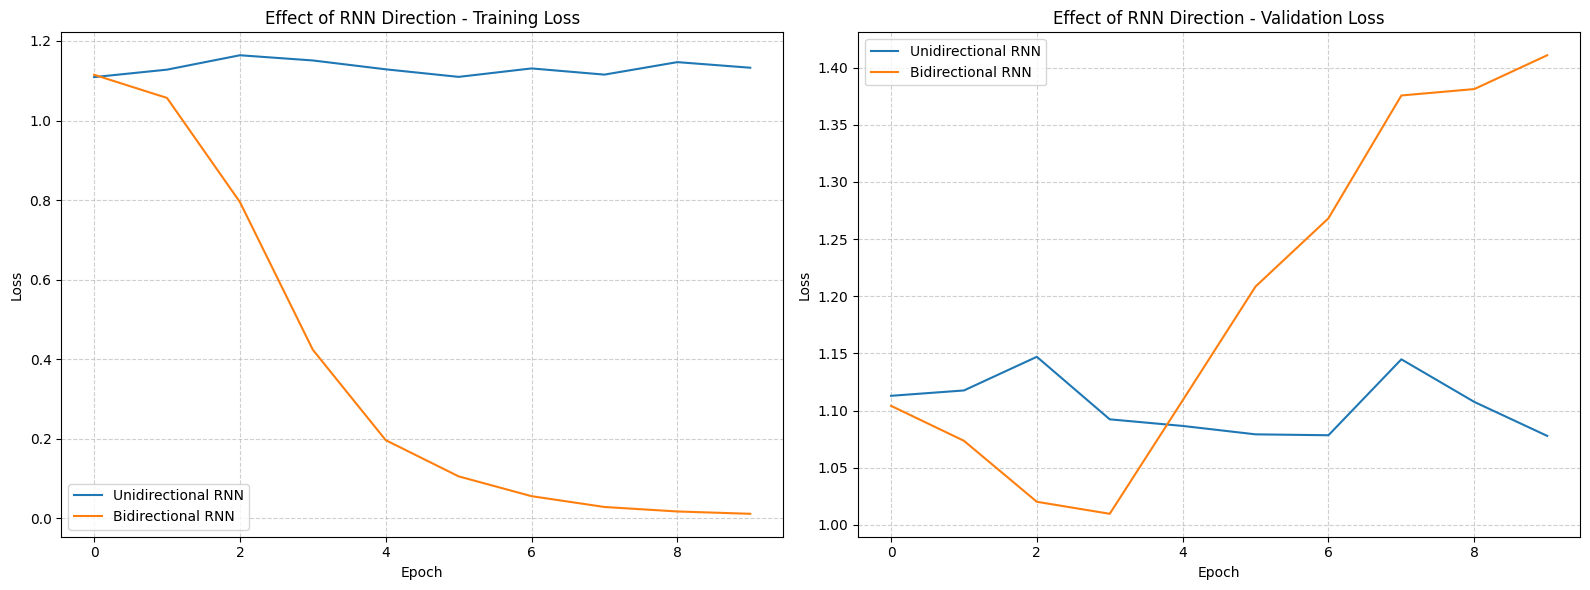

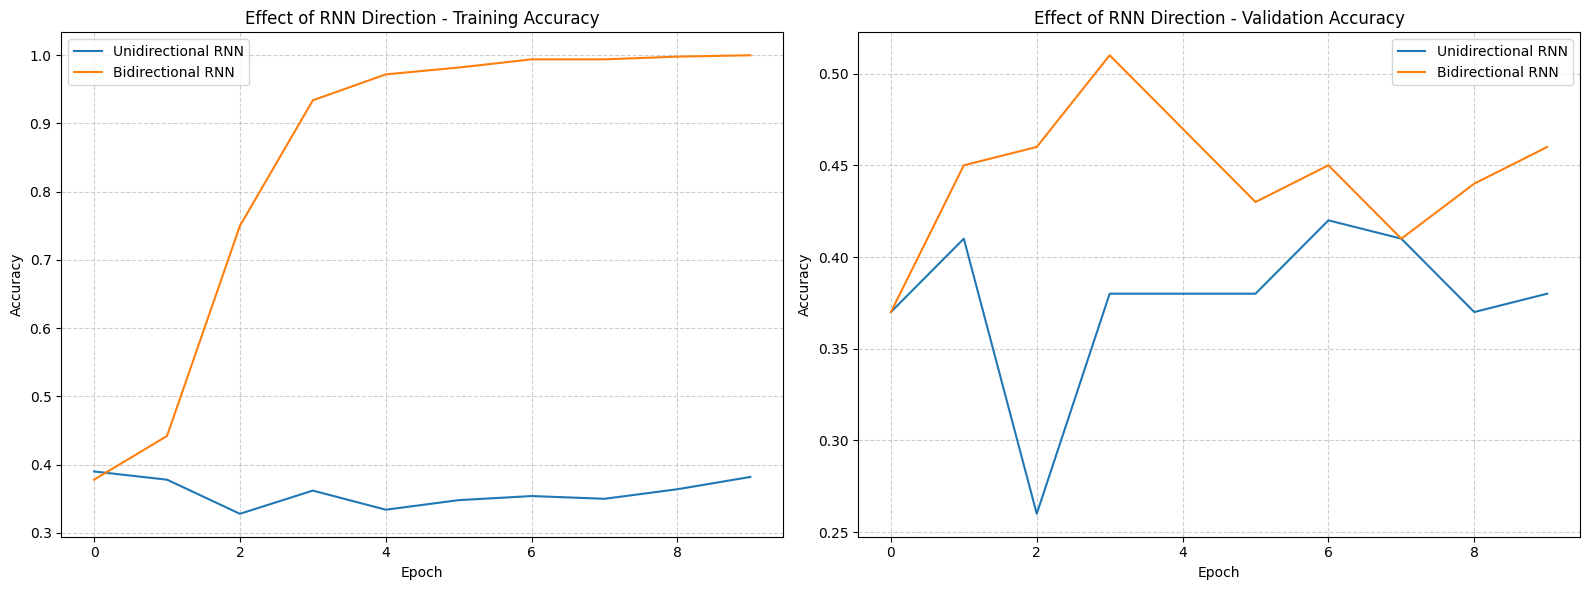

In [12]:
# Define variants for RNN direction
direction_variants = [
    (False, "Unidirectional RNN"),
    (True, "Bidirectional RNN")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)

## 3. From-Scratch RNN Implementation

In [14]:
# Choose one of the trained models (e.g., from the bidirectional experiment)
keras_model_path = "../../output/models/rnn/rnn_bidirectional.keras"
if os.path.exists(keras_model_path):
    keras_model = load_model(keras_model_path)
elif len(direction_models) > 1 and direction_models[1][0] is not None:
    keras_model = direction_models[1][0]  # Bidirectional RNN model
else:
    keras_model = direction_models[0][0]  # Unidirectional RNN model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('../output/models/rnn/rnn_model.weights.h5')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

In [15]:
# Get embedding dimension and vocabulary size
embedding_dim = 100
vocab_size = len(data_loader.get_vocabulary())
hidden_dim = 128
num_classes = data_loader.num_classes
sequence_length = data_loader.max_sequence_length
bidirectional = True  # Set this based on the chosen model

# Create a from-scratch RNN model that matches the Keras model
scratch_model = RNNModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(EmbeddingLayer(input_dim=vocab_size, output_dim=embedding_dim))
scratch_model.add(RNNLayer(input_dim=embedding_dim, hidden_dim=hidden_dim, bidirectional=bidirectional, return_sequences=False))
scratch_model.add(DropoutLayer(dropout_rate=0.2))
scratch_model.add(DenseLayer(input_dim=hidden_dim*2 if bidirectional else hidden_dim, output_dim=num_classes))
scratch_model.add(Softmax())

# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

Weights loaded from Keras model to from-scratch implementation.


In [16]:
# Get test data
x_test, y_test = data_loader.get_vectorized_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=32)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Layer 0 input shape: (400, 100)
Layer 1 input shape: (400, 100, 100)
Layer 2 input shape: (400, 256)
Layer 3 input shape: (400, 256)
Layer 4 input shape: (400, 3)
Model output shape: (400, 3)

Keras Model Metrics:
Accuracy: 0.4600
Macro F1-Score: 0.4446

From-Scratch Model Metrics:
Accuracy: 0.4425
Macro F1-Score: 0.4237

Model Agreement: 0.9275


In [17]:
# Get a few test samples
num_samples = 5
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_texts = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_texts), axis=1)
scratch_preds = scratch_model.predict(sample_texts)

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Visualize the results
for i in range(num_samples):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_texts[i] if idx > 0]
    text = " ".join(words)
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    print(f"\nText: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"True sentiment: {sentiment_labels[sample_labels[i]]}")
    print(f"Keras prediction: {sentiment_labels[keras_preds[i]]} {'✓' if keras_correct else '✗'}")
    print(f"Scratch prediction: {sentiment_labels[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Layer 0 input shape: (5, 100)
Layer 1 input shape: (5, 100, 100)
Layer 2 input shape: (5, 256)
Layer 3 input shape: (5, 256)
Layer 4 input shape: (5, 3)
Model output shape: (5, 3)

Text: mengunjungi tempat ini untuk istirahat setelah [UNK] macet di perjalanan makanan oke tapi [UNK] mant...
True sentiment: Positive
Keras prediction: Positive ✓
Scratch prediction: Positive ✓

Text: tidak mengerti ya kenapa resto ini menduduki peringkat 12 dari [UNK] resto yang ada di jakarta harga...
True sentiment: Negative
Keras prediction: Positive ✗
Scratch prediction: Positive ✗

Text: restoran seafood menu [UNK] kepiting yang [UNK] dengan [UNK] untuk saya kurang enak [UNK] masih agak...
True sentiment: Negative
Keras prediction: Positive ✗
Scratch prediction: Positive ✗

Text: jangan [UNK] diskon langsung hingga rp 10 juta di sini
True sentiment: Neutral
Keras prediction: Positive ✗
Scratch prediction: Positive ✗

Text: saya sudah [UNK] ke email [UNK]
True sen

## 4. Additional Experiments: Multi-layer RNN Models

In [18]:
# Ensure output directories exist
os.makedirs("../../output/models/rnn", exist_ok=True)
os.makedirs("../../output/results/rnn", exist_ok=True)

In [19]:
# Load models from previously saved files
model_paths = {
    "1_layer": "../../output/models/rnn/1_layer_rnn.keras",
    "2_layer": "../../output/models/rnn/2_layer_rnn.keras",
    "3_layer": "../../output/models/rnn/3_layer_rnn.keras"
}

loaded_models = {}

for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"Loading model: {name}")
        loaded_models[name] = load_model(path)
        loaded_models[name].summary()
    else:
        print(f"Model file not found: {path}")

Model file not found: ../../output/models/rnn/1_layer_rnn.keras
Model file not found: ../../output/models/rnn/2_layer_rnn.keras
Model file not found: ../../output/models/rnn/3_layer_rnn.keras


In [20]:
# Compare the multi-layer models
results = {}

for name, path in model_paths.items():
    if not os.path.exists(path):
        print(f"Model file not found: {path}")
        continue
        
    print(f"\nBuilding and comparing {name} model...")
    
    # Create a matching from-scratch model for each Keras model
    try:
        comparison_result = experiments.compare_models(keras_model_path=path)
        
        # Store the results
        results[name] = comparison_result
        
        # Print key metrics
        print("\nComparison Results:")
        print(f"Keras Accuracy: {comparison_result['keras_metrics']['accuracy']:.4f}")
        print(f"Scratch Accuracy: {comparison_result['scratch_metrics']['accuracy']:.4f}")
        print(f"Model Agreement: {comparison_result['model_agreement']:.4f}")
        
    except Exception as e:
        print(f"Error processing model {name}: {e}")
        import traceback
        traceback.print_exc()

Model file not found: ../../output/models/rnn/1_layer_rnn.keras
Model file not found: ../../output/models/rnn/2_layer_rnn.keras
Model file not found: ../../output/models/rnn/3_layer_rnn.keras


In [21]:
# Visualize agreement between Keras and from-scratch models
if results:
    model_names = list(results.keys())
    agreements = [results[name]['model_agreement'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, agreements, color='skyblue')
    plt.title('Agreement Between Keras and From-Scratch Models')
    plt.xlabel('Model')
    plt.ylabel('Agreement')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    
    # Add agreement values on top of bars
    for i, v in enumerate(agreements):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('../../output/results/rnn/model_agreement.png')
    plt.show()